In [1]:
%matplotlib inline 

# Pairwise Ranking of Features

![Rank 1D Histogram](../figures/rank_1d_hist.png)

![Rank 1D Histogram](../figures/rank_1d_box.png)

![Rank 1D Histogram](../figures/rank_2d.png)

![Rank 1D Histogram](../figures/joint.png)

In [2]:
# Imports 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from ipywidgets import interact, interactive, fixed

import ipywidgets as widgets

In [12]:
# Data Loading 
columns = OrderedDict([
    ("DAY", "the day of data collection"),
    ("Q-E", "input flow to plant"),
    ("ZN-E", "input Zinc to plant"),
    ("PH-E", "input pH to plant"),
    ("DBO-E", "input Biological demand of oxygen to plant"),
    ("DQO-E", "input chemical demand of oxygen to plant"),
    ("SS-E", "input suspended solids to plant"),
    ("SSV-E", "input volatile supended solids to plant"),
    ("SED-E", "input sediments to plant"),
    ("COND-E", "input conductivity to plant"),
    ("PH-P", "input pH to primary settler"),
    ("DBO-P", "input Biological demand of oxygen to primary settler"),
    ("SS-P", "input suspended solids to primary settler"),
    ("SSV-P", "input volatile supended solids to primary settler"),
    ("SED-P", "input sediments to primary settler"),
    ("COND-P", "input conductivity to primary settler"),
    ("PH-D", "input pH to secondary settler"),
    ("DBO-D", "input Biological demand of oxygen to secondary settler"),
    ("DQO-D", "input chemical demand of oxygen to secondary settler"),
    ("SS-D", "input suspended solids to secondary settler"),
    ("SSV-D", "input volatile supended solids to secondary settler"),
    ("SED-D", "input sediments to secondary settler"),
    ("COND-S", "input conductivity to secondary settler"),
    ("PH-S", "output pH"),
    ("DBO-S", "output Biological demand of oxygen"),
    ("DQO-S", "output chemical demand of oxygen"),
    ("SS-S", "output suspended solids"),
    ("SSV-S", "output volatile supended solids"),
    ("SED-S", "output sediments"),
    ("COND-", "output conductivity"),
    ("RD-DB-P", "performance input Biological demand of oxygen in primary settler"),
    ("RD-SSP", "performance input suspended solids to primary settler"),
    ("RD-SE-P", "performance input sediments to primary settler"),
    ("RD-DB-S", "performance input Biological demand of oxygen to secondary settler"),
    ("RD-DQ-S", "performance input chemical demand of oxygen to secondary settler"),
    ("RD-DB-G", "global performance input Biological demand of oxygen"),
    ("RD-DQ-G", "global performance input chemical demand of oxygen"),
    ("RD-SSG", "global performance input suspended solids"),
    ("RD-SED-G", "global performance input sediments"),
])

data = pd.read_csv("../data/water-treatment.data", names=columns.keys())
data = data.replace('?', np.nan)

In [13]:
# Capture only the numeric columns in the data set. 
numeric_columns = [col for col in columns.keys() if col != "DAY"]
data = data[numeric_columns].apply(pd.to_numeric)

## 2D Rank Features 

In [14]:
def apply_column_pairs(func):
    """
    Applies a function to a pair of columns and returns a new 
    dataframe that contains the result of the function as a matrix
    of each pair of columns. 
    """
    
    def inner(df):
        cols = pd.DataFrame([
            [
                func(df[acol], df[bcol]) for bcol in df.columns
            ] for acol in df.columns
        ])

        cols.columns = df.columns
        cols.index = df.columns 
        return cols

    return inner 


@apply_column_pairs
def least_square_error(cola, colb):
    """
    Computes the Root Mean Squared Error of a linear regression 
    between two columns of data. 
    """
    x = cola.fillna(np.nanmean(cola))
    y = colb.fillna(np.nanmean(colb))
    
    m, b = np.polyfit(x, y, 1)
    yh  = (x * m) + b 
    return ((y-yh) ** 2).mean()

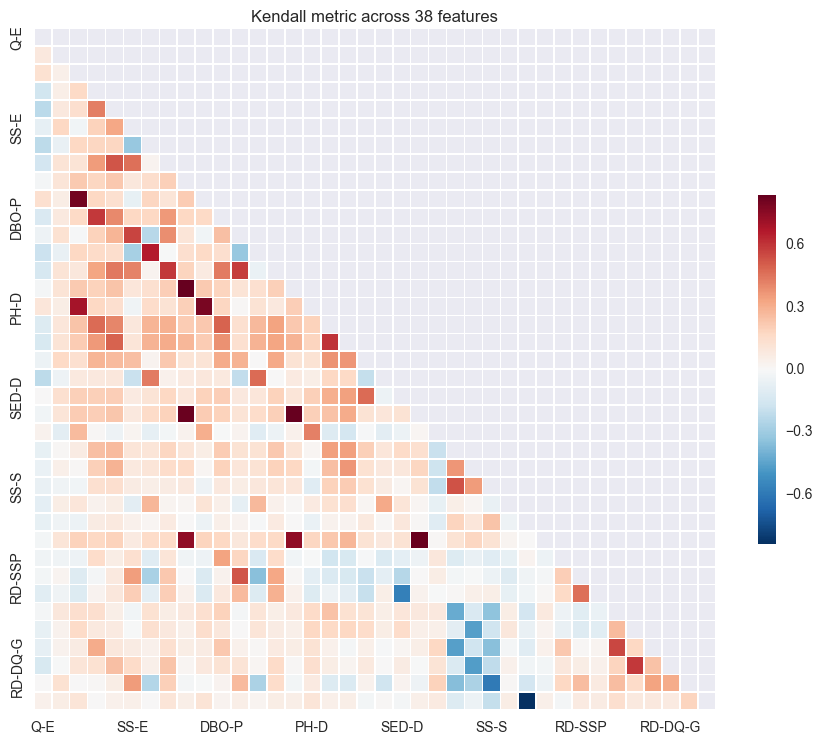

In [15]:
labeled_metrics = {
    'Pearson': 'pearson', 
    'Kendall Tao': 'kendall', 
    'Spearman': 'spearman', 
    'Pairwise Covariance': 'covariance',
    'Least Squares Error': 'lse', 
}

@interact(metric=labeled_metrics, data=fixed(data))
def rank2d(data, metric='pearson'):
    """
    Creates a visualization of pairwise ranking by column in the data. 
    """
    
    # The different rank by 2d metrics. 
    metrics = {
        "pearson": lambda df: df.corr('pearson'), 
        "kendall": lambda df: df.corr('kendall'), 
        "spearman": lambda df: df.corr('spearman'), 
        "covariance": lambda df: df.cov(), 
        "lse": least_square_error,
    }
    
    # Quick check to make sure a valid metric is passed in. 
    if metric not in metrics:
        raise ValueError(
            "'{}' not a valid metric, specify one of {}".format(
                metric, ", ".join(metrics.keys())
            )
        )
    
    
    # Compute the correlation matrix
    corr = metrics[metric](data)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    ax.set_title("{} metric across {} features".format(metric.title(), len(data.columns)))
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, vmax=.3,
                square=True, xticklabels=5, yticklabels=5,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)